In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

train=pd.read_csv('train_features.csv')
train_labels=pd.read_csv('train_labels.csv')
test=pd.read_csv('test_features.csv')
submission=pd.read_csv('sample_submission.csv')

In [2]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [62]:
train_labels #Non-Exercise도 고려를 해야하는것일까?

,id,label
0,0,37
1,1,26
2,2,3
3,3,26
4,4,26
...,...,...
3120,3120,26
3121,3121,26
3122,3122,15
3123,3123,26


In [6]:
train_labels.columns

Index(['id', 'label', 'label_desc'], dtype='object')

In [7]:
train.columns

Index(['id', 'time', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z'], dtype='object')

생각
1) train_labels의 데이터들을 label별로 모으기
2) 각 label별로

In [47]:
test

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,3125,0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668
1,3125,1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458
2,3125,2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043
3,3125,3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771
4,3125,4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912
...,...,...,...,...,...,...,...,...
469195,3906,595,0.104191,-0.784979,0.639513,-10.475346,14.095361,-190.358982
469196,3906,596,0.103297,-0.758954,0.615687,-25.360272,-8.523018,-180.393291
469197,3906,597,0.128294,-0.749389,0.586184,-27.917723,-23.186245,-162.624160
469198,3906,598,0.104130,-0.692731,0.573397,-27.847980,-30.407555,-138.761676


In [33]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,1875000.0,1562.000000,902.109990,0.000000,781.000000,1562.000000,2343.000000,3124.000000
time,1875000.0,299.500000,173.204886,0.000000,149.750000,299.500000,449.250000,599.000000
acc_x,1875000.0,-0.448968,0.717308,-8.838427,-0.962564,-0.656048,-0.000170,8.426799
acc_y,1875000.0,-0.161791,0.587202,-9.299714,-0.516302,-0.203398,0.140649,8.484622
acc_z,1875000.0,0.055715,0.472482,-8.316425,-0.212355,0.030313,0.358198,6.432668
gy_x,1875000.0,-1.307982,60.832285,-1811.126713,-20.489839,-1.421819,15.722455,1870.255994
gy_y,1875000.0,-0.433774,73.298318,-1594.255615,-18.653199,-0.264275,16.763278,2111.656826
gy_z,1875000.0,0.886410,70.633454,-1346.142960,-15.462257,-0.179864,16.418782,1255.849180


In [34]:
def plot_acc_id(df, id_num):
    return df.query('id == @id_num')[['time', 'acc_x', 'acc_y', 'acc_z']].plot(x = 'time')

def plot_gy_id(df, id_num):
    return df.query('id == @id_num')[['time', 'gy_x', 'gy_y', 'gy_z']].plot(x = 'time')

(-2.5, 2.5)

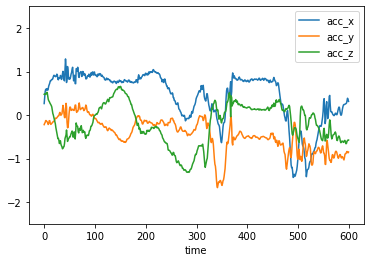

In [35]:
plot_acc_id(train, 122)

plt.ylim((-2.5, 2.5))

In [51]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [69]:
train_labels_merge=pd.merge(train,train_labels,on="id")
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']
X_train = train[features].groupby('id').mean()
Y_train = train_labels['label']
X_test = test[features].groupby('id').mean()
X_train.shape,Y_train.shape, X_test.shape

((3125, 6), (3125,), (782, 6))

In [91]:
# Knn
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
Y_pred

submission.iloc[:,1:] = Y_pred
submission
submission.to_csv('baseline_rf.csv', index=False)

ValueError: Must have equal len keys and value when setting with an iterable

In [88]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict_proba(X_test)
Y_pred

submission.iloc[:,1:] = Y_pred
submission
submission.to_csv('baseline_rf.csv', index=False)